In [269]:
import yfinance as yf 
import pandas as pd
import numpy as np
from datetime import datetime

import quandl

import sys
import urllib
import os
from matplotlib import pylab as plt 

import quandl

import seaborn as sns

import sys

from scipy.stats import norm
import ezodf

import scipy.optimize as sco
import scipy

from sklearn.covariance import LedoitWolf
import sklearn.datasets, sklearn.decomposition

In [2]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}", 'Volatility': "{:.1%}",
              'Sharpe': "{:.1f}",'MAR': "{:.2f}", 'Sortino': "{:.1f}" })
      .set_table_styles(styles)
      .set_properties(**{'color': 'black'}))
    
    return metrics


def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    


    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        

        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0]))]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 



def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret


def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles)
          .set_properties(**{'color': 'black'}))
    
    return corr

In [3]:
def calc_bond_returns(YTM, YTMM1, M, FREQ = 12):
    DY = YTM - YTMM1
    yield_income = (1+YTM)**(1/FREQ) - 1
    Z = (1+(YTM/2))
    

    duration = (1/YTM)* (1 -(1/(1+0.5*YTM)**(2*M)))


    C1 = (2/YTM**2) * (1-Z**(-2*M))
    C2 = ((2*M)/YTM) * Z **(-2*M - 1) 
    convex = C1-C2

    ret = yield_income - duration* DY + (1/2)*convex * (DY**2)
    return(ret)



def monthly_bonds_ret(bond_YTM, M):
    bond_ret = [0]

    for i in range(len(bond_YTM)-1):
        YTM = bond_YTM[i+1]
        YTMM1 = bond_YTM[i]
        
        ret = calc_bond_returns(YTM, YTMM1, M)
        bond_ret.append(ret)

    bond_ret = pd.DataFrame(bond_ret)
    #bond_ret.index = bond_YTM.index + pd.Timedelta('1 day')
    bond_ret.index = bond_YTM.index
    
    bond_ret = (bond_ret+1).cumprod()
    return(bond_ret)


In [267]:
def PCA_cov(data, N = 5):
    #X = data.cov()
    
    X = data.ewm(span = 252).cov()
    DATE_IDX = X.index.get_level_values(level=0)[-1]
    X = X[X.index.get_level_values(0)==DATE_IDX].droplevel(0)
    mu = np.mean(X, axis=0)

    pca = sklearn.decomposition.PCA()
    pca.fit(X)

    nComp = N
    Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:])
    Xhat += mu
    clean_cov = pd.DataFrame(Xhat)
    clean_cov.index = X.index
    clean_cov.columns = X.index
    return(clean_cov)

## Implementation of MAN AHL Trend System,

- use multiple MAs
- Weight by signal strength

In [63]:
def risk_parity(data):
    
    vol = data.std()

    sum_vol = 0
    for i in range(len(vol)):
        sum_vol =sum_vol + (1/vol[i])
    
    weight = []
    for i in range(len(vol)):
        w = (1/vol[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)


def equal_weight(data):
    num_assets = len(data.columns)
    weight = num_assets*[1./num_assets,]
    
    return(weight)
    

def get_weights(data, method, lookback):
    weights = []
 

    for i in range(lookback,len(data)):
    
        W= method(data[i-lookback:i])
        weights.append(W)

    weights = pd.DataFrame(weights)
    weights.index = data[lookback:].index
    weights.columns = data.columns
    
    return(weights)

In [293]:
def ERC_weight(data):
    
    num_assets = len(data.columns)
    #data = data.dropna()
    cov_fit = LedoitWolf().fit(data)
    cov = cov_fit.covariance_

        
    args = (cov)
    constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
    result = sco.minimize(erc, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.00000000000000000000000000000000000001)
    weights = result['x']
        
        
        
    
    return (weights)

def kelly_objective(weights,ret, cov, risk_free = 0):
    
    #kelly_ret = port_ret(weights, ret)
    kelly_ret = port_ret(weights, ret) - port_var(weights, cov)/2
    
    obj = -(kelly_ret)
    
    return(obj)

def sharpe_objective(weights,ret, cov, risk_free = 0):
    ret = port_ret(weights, ret)
    std = port_var(weights, cov)**(1/2)
    
    obj = - (ret/std)
    return(obj)


def port_var(weights, cov):
    var = weights.dot(cov).dot(weights)
    return(var)

def port_ret(weights, ret, risk_free = 0):
    #needs to be array
    ret = ret - risk_free
    port_ret = weights.dot(ret)
    return(port_ret)



def calc_diversification_ratio(weights, cov):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(cov)), weights.T)
    # portfolio vol
    port_vol = np.sqrt(port_var(weights, cov))
    
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

def erc(weights, cov):
        # these are non normalized risk contributions, i.e. not regularized
        # by total risk, seems to help numerically
        risk_contributions = np.dot(weights, cov) * weights
        a = np.reshape(risk_contributions, (len(risk_contributions), 1))
        # broadcasts so you get pairwise differences in risk contributions
        risk_diffs = a - a.transpose()
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))/10000000
        # https://stackoverflow.com/a/36685019/1451311
        return sum_risk_diffs_squared #/ scale_factorcov

In [519]:
TICKS = ['TLT','^SP500TR', 'GLD']
assets_df = pd.DataFrame()
for tick in TICKS:
    
    price = yf.download(tick,start='2000-01-01', progress = False, threads = False)
    price = price['Adj Close']
    assets_df[tick] = price

ret_df = assets_df.pct_change()
ret_df= ret_df.dropna()

In [520]:
lookback = 252
target_vol = 0.065

log_ret = np.log(assets_df) - np.log(assets_df.shift(1))
log_ret = log_ret.dropna()

RP_weights = get_weights(log_ret,risk_parity, lookback )

RP_ret = pd.DataFrame(np.multiply(RP_weights,ret_df.loc[ret_df.index.isin(RP_weights.index)]).sum(axis =1))[lookback:]
RP_ret.columns = ['Risk Parity']

EW_weights = get_weights(log_ret,equal_weight, lookback )
EW_ret = pd.DataFrame(np.multiply(EW_weights,ret_df.loc[ret_df.index.isin(EW_weights.index)]).sum(axis =1))[lookback:]
EW_ret.columns = ['Equal Weight']

ERC_weights = get_weights(log_ret,ERC_weight, lookback )
ERC_ret = pd.DataFrame(np.multiply(ERC_weights,ret_df.loc[ret_df.index.isin(ERC_weights.index)]).sum(axis =1))[lookback:]
ERC_ret.columns = ['ERC']


In [521]:
### VOL TARGET EQUAL WEIGHT
EW_vol = np.log(1+EW_ret).ewm(10).std()*np.sqrt(252)
EW_gearing = target_vol/EW_vol
EW_vol_ret = EW_gearing.shift(1) * EW_ret
EW_vol_ret.columns = ['Equal Weight TV']

### VOL TARGET EQUAL WEIGHT
ERC_vol = np.log(1+ERC_ret).ewm(10).std()*np.sqrt(252)
ERC_gearing = target_vol/ERC_vol
ERC_vol_ret = ERC_gearing.shift(1) * ERC_ret
ERC_vol_ret.columns = ['ERC TV']

In [522]:
### TO DO
### ADD SIGNAL STRENGTH PARAMETER TO ADJUST ROLLING RISK. GOOD OPPORTUNITIES LEAD TO HIGHER RISK
### RISK = TARGET VOl * TREND STRENGTH
### COPY ROBERT CARVER
# trend_df = assets_df
# lookback = [21, 31,63]
# vol_lookback = max(lookback)
# vol = trend_df.rolling(vol_lookback).std()

# look_back_dict = {}
# df_signals = pd.DataFrame()
# for look in lookback:
#     trend_tmp = trend_df.ewm(span=look).mean() - trend_df.ewm(span=4*look).mean()
#     scld_trend = trend_tmp/vol
#     trend_norm = scld_trend/scld_trend.rolling(252).std()
#     look_back_dict[look] = trend_norm
#     df_signals = df_signals.add(trend_norm, fill_value=0)
#     #Set positive to one, set negative to 0
#     #df_signals[df_signals>0] = 1
#     #df_signals[df_signals<=0] = 0

# df_signals = df_signals/len(lookback)
# df_signals = df_signals.shift(1)
# EWMA_ret = pd.DataFrame(np.multiply(df_signals,ret_df[len(ret_df) - len(df_signals):]).sum(axis =1))
# EWMA_vol = np.log(1+EWMA_ret).rolling(60).std()*np.sqrt(252)
# gearing = target_vol/EWMA_vol
# EWMA_vol_ret = gearing * EWMA_ret
# EWMA_vol_ret.columns = ['EWMA Trend Following']


In [523]:
# ##TIME SERIES MOM, USE 3 month and 12 month lookback
# trend_df = assets_df.copy()
# lookback = [30,252]
# vol_lookback = max(lookback)
# vol = trend_df.rolling(vol_lookback).std()

# look_back_dict = {}
# df_signals = pd.DataFrame()
# for look in lookback:
#     trend_tmp = trend_df.pct_change(look)
#     scld_trend = trend_tmp/vol
#     trend_norm = scld_trend/scld_trend.rolling(252).std()
#     trend_sig = (trend_norm * np.exp((-trend_norm**2)/4))/0.89
#     trend_sig = trend_sig.dropna()
#     look_back_dict[look] = trend_sig
#     df_signals = df_signals.add(trend_sig, fill_value=0)
#     #Set positive to one, set negative to 0
#     df_signals[df_signals>0] = 1
#     df_signals[df_signals<=0] = 0
    
# df_signals = df_signals/len(lookback)
# df_signals = df_signals.shift(1)
# TS_ret = pd.DataFrame(np.multiply(df_signals,ret_df[len(ret_df) - len(df_signals):]).sum(axis =1))
# TS_vol = np.log(1+TS_ret).rolling(60).std()*np.sqrt(252)
# gearing = target_vol/TS_vol
# TS_vol_ret = gearing * TS_ret
# TS_vol_ret.columns = ['TS Trend Following']

In [524]:
# ### Rank Trend, Dual Momentum inspired. Take top 2 based on past 12 months, rebalance monthly,
# # require positive ABS mom.
# top_n_assets = 2
# rebal_freq = 21

# DM_df = assets_df.copy()
# REL_mom_df = DM_df.pct_change(252)
# RANK_df=REL_mom_df.rank(axis=1,ascending=False)
# ABS_mom_df = REL_mom_df.copy()
# ABS_mom_df[ABS_mom_df>0] = 1
# ABS_mom_df[ABS_mom_df<=0] = 0

# for col in RANK_df.columns:
#     RANK_df[col]=np.where(RANK_df[col]<=top_n_assets, 1, 0)

# COMB_df = np.multiply(RANK_df,ABS_mom_df)
# tmp_idx = COMB_df.index
# COMB_df = COMB_df[::rebal_freq]
# COMB_df = COMB_df.reindex(tmp_idx).ffill().shift(1)


# COMB_ret_df = np.multiply(COMB_df,ret_df)
# COMB_ret_df=COMB_ret_df.sum(axis =1)/top_n_assets
# COMB_ret_df = pd.DataFrame(COMB_ret_df, columns = ["DM"])

In [525]:
# ### Dual Mom, use gold and stocks for EXAMPle
# test_df = assets_df[['Gold', 'SP500']]
# lookback = 252
# weights = []
 

# for i in range(lookback, len(test_df)):
#     ret_rank = test_df[:i].pct_change(lookback).tail(1).rank(axis = 1, ascending = False )
#     ret_abs = test_df[:i].pct_change(lookback).tail(1)>0
#     W = (ret_rank == 1 & ret_abs).astype(int)
#     weights.append(W.values[0])

# weights = pd.DataFrame(weights)
# weights.index = test_df[lookback:].index
# weights.columns = test_df.columns

# DM_ret = pd.DataFrame(np.multiply(weights,test_df[lookback:].pct_change()).sum(axis =1))[lookback:]
# DM_ret.columns = ['Dual']


## Create Comparison

In [526]:
port_rets_df = pd.concat([EW_ret,ERC_ret,EW_vol_ret,ERC_vol_ret], axis = 1).dropna()

port_rets_df = (port_rets_df+1).cumprod()

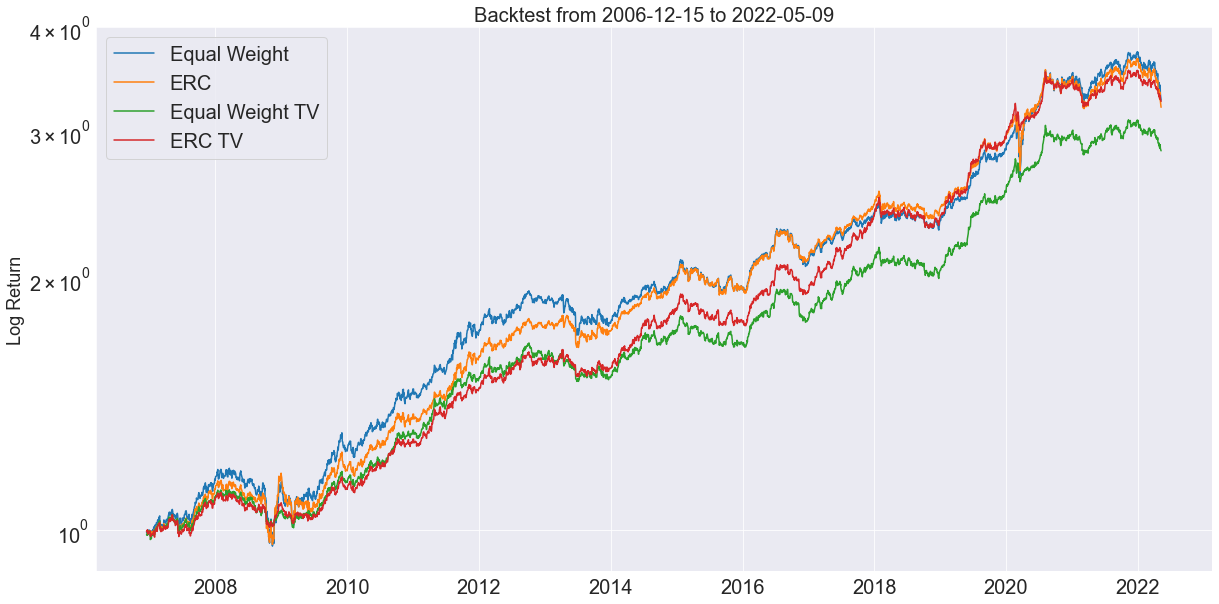

In [527]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in port_rets_df.columns:
    plt.plot(port_rets_df[i], label = i);
start = datetime.date(port_rets_df.index.min());    
end = datetime.date(port_rets_df.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [528]:
strategy_evaluation(port_rets_df, port_rets_df.columns, freq = 'D')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR
Equal Weight,8.1%,9.5%,0.8,1.1,-19.0%,0.43
ERC,7.9%,8.7%,0.9,1.1,-16.0%,0.50
Equal Weight TV,7.1%,7.0%,1.0,1.4,-10.0%,0.71
ERC TV,8.0%,7.0%,1.1,1.6,-9.0%,0.89


In [529]:
correlation_map(port_rets_df)

,Equal Weight,ERC,Equal Weight TV,ERC TV
Equal Weight,1.00,0.97,0.91,0.88
ERC,0.97,1.00,0.89,0.91
Equal Weight TV,0.91,0.89,1.00,0.97
ERC TV,0.88,0.91,0.97,1.00


In [530]:
###PLOT WEIGHT FROM THE DIFFERENT SCHEMAS

<AxesSubplot:xlabel='Date'>

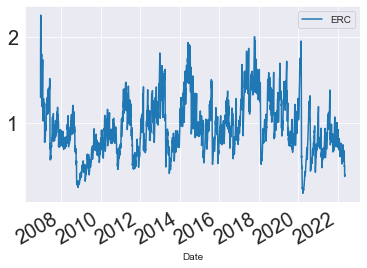

In [531]:
ERC_gearing.dropna().plot()

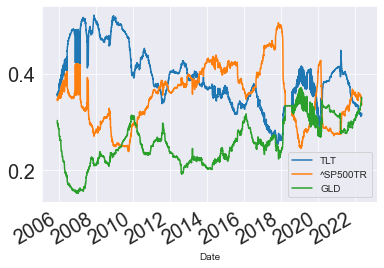

In [539]:
ERC_weights.plot();

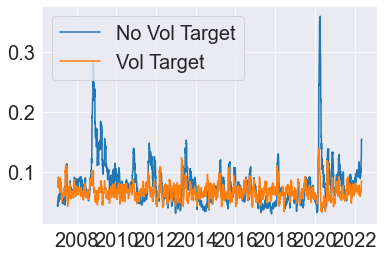

In [533]:
plt.plot(ERC_ret.rolling(20).std()*np.sqrt(252), label = 'No Vol Target');
plt.plot(ERC_vol_ret.rolling(20).std()*np.sqrt(252), label = 'Vol Target');
plt.legend(loc=2, prop={'size': 20});

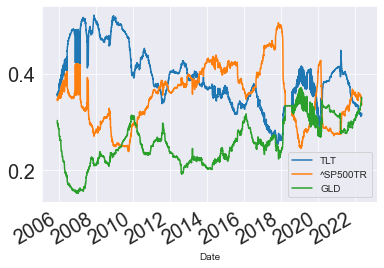

In [538]:
ERC_weights.plot();